In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Model Garden Keras YOLOv8
<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_keras_yolov8.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>

  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_keras_yolov8.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/model_garden/model_garden_keras_yolov8.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
Open in Vertex AI Workbench
    </a>
  </td>
</table>

**_NOTE_**: This notebook has been tested in the following environment:

* Python version = 3.9

You can open this notebook directly in Colab, or create [google managed](https://cloud.google.com/vertex-ai/docs/workbench/managed/create-instance) or [user managed](https://cloud.google.com/vertex-ai/docs/workbench/user-managed/create-new) Workbench instances.

## Overview

This notebook demonstrates how to use [Keras YOLOv8](https://keras.io/api/keras_cv/models/tasks/yolo_v8_detector/) in Vertex AI Model Garden.

### Objective

* Run local inferences for pretrained or customized models

* Deploy pretrained or customized models in Google Cloud Vertex AI

* Finetune models in Google Cloud Vertex AI

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Dataset


The dataset used for this tutorial is the Salads category of the [OpenImages dataset](https://www.tensorflow.org/datasets/catalog/open_images_v4) from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview). This dataset does not require any feature engineering. The version of the dataset you will use in this tutorial is stored in a public Cloud Storage bucket. The trained model predicts the bounding box locations and corresponding type of salad items in an image from a class of five items: Salad, Seafood, Tomato, Baked Goods, or Cheese.

## Installation

Install the following packages required to execute this notebook.

In [4]:
! pip3 install --quiet --force-reinstall protobuf==3.20.3
! pip3 install --quiet keras-cv==0.6.1
! pip3 install --quiet keras-core==0.1.0
! pip3 install --user --force-reinstall tensorflow==2.15.0

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI API and Compute Engine API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component).
1. If you are running this notebook locally, you will need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

### Set your project, region and buckets

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

You can change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

You can create a storage bucket to store intermediate artifacts such as datasets, trained models etc.

In [11]:
# The project and bucket are for experiments below.
PROJECT_ID = "donuts-dev"  # @param {type:"string"}

# The form for BUCKET_URI is gs://<bucket-name>.
BUCKET_URI = "gs://donuts-dev-usc1"  # @param {type:"string"}
REGION = "us-central1"  # @param {type: "string"}

import os

STAGING_BUCKET = os.path.join(BUCKET_URI, "temporal")
MODEL_BUCKET = os.path.join(STAGING_BUCKET, "keras_yolov8")

Updated property [core/project].


### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project.

In [12]:
from google.cloud import aiplatform 

aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=STAGING_BUCKET)

### Define constants and common functions

In [3]:
import base64
import io
from datetime import datetime
from typing import Dict, List, Union

import keras_cv
import numpy as np
import tensorflow as tf
import yaml
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
from keras_cv import visualization
from PIL import Image

TRAIN_MACHINE_TYPE = "n1-highmem-16"
TRAIN_ACCELERATOR_TYPE = "NVIDIA_TESLA_V100"
TRAIN_NUM_GPU = 2
TRAIN_CONTAINER_URI = (
    "us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/keras-yolov8-train"
)
TRAINING_JOB_PREFIX = "train_yolov8"

UPLOAD_JOB_PREFIX = "upload_yolov8"
DEPLOY_JOB_PREFIX = "deploy_yolov8"
SERVING_CONTAINER_URI = (
    "us-docker.pkg.dev/vertex-ai-restricted/prediction/tf_opt-gpu.2-12:latest"
)
SERVING_ACCELERATOR_TYPE = "NVIDIA_TESLA_T4"
SERVING_MACHINE_TYPE = "n1-standard-4"
SERVING_CONTAINER_ARGS = ["--allow_precompilation", "--allow_compression"]

RESOLUTION = 512


def get_job_name_with_datetime(prefix: str):
    """Generates a job name with date time when triggering training or deployment
    jobs in Vertex AI.
    """
    return prefix + datetime.now().strftime("_%Y%m%d_%H%M%S")


def load_img(path):
    """Reads image from path and return PIL.Image instance."""
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return Image.fromarray(np.uint8(img)).convert("RGB")


def decode_image(image_str_tensor: tf.string) -> tf.float32:
    """Converts and resizes image bytes to image tensor."""
    image = tf.io.decode_image(image_str_tensor, 3, expand_animations=False)
    image = tf.image.resize(image, (RESOLUTION, RESOLUTION))
    return image


def get_label_map(label_map_yaml_filepath):
    """Returns class id to label mapping given a filepath to the label map."""
    with tf.io.gfile.GFile(label_map_yaml_filepath, "rb") as input_file:
        label_map = yaml.safe_load(input_file.read())["label_map"]
    return label_map


def get_prediction_instances(test_filepath, new_width=-1):
    """Generate instance from image path to pass to Vertex AI Endpoint for prediction."""
    if new_width <= 0:
        with tf.io.gfile.GFile(test_filepath, "rb") as input_file:
            encoded_string = base64.b64encode(input_file.read()).decode("utf-8")
    else:
        img = load_img(test_filepath)
        width, height = img.size
        print("original input image size: ", width, " , ", height)
        new_height = int(height * new_width / width)
        new_img = img.resize((new_width, new_height))
        print("resized input image size: ", new_width, " , ", new_height)
        buffered = io.BytesIO()
        new_img.save(buffered, format="JPEG")
        encoded_string = base64.b64encode(buffered.getvalue()).decode("utf-8")

    instances = [
        {
            "encoded_image": {"b64": encoded_string},
        }
    ]
    return instances


def predict_custom_trained_model(
    project: str,
    endpoint_id: str,
    instances: Union[Dict, List[Dict]],
    location: str = "us-central1",
):
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": f"{location}-aiplatform.googleapis.com"}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)
    parameters_dict = {}
    parameters = json_format.ParseDict(parameters_dict, Value())
    endpoint = client.endpoint_path(
        project=project, location=location, endpoint=endpoint_id
    )
    response = client.predict(
        endpoint=endpoint, instances=instances, parameters=parameters
    )
    return response.predictions, response.deployed_model_id

Using TensorFlow backend


## Finetune models
This section shows how to finetune the Keras YOLOv8 model with training dockers and then deploy to Vertex AI Endpoint resource. The accepted dataset format is a CSV formatted as it would for [AutoML Image Object Detection](https://cloud.google.com/vertex-ai/docs/image-data/object-detection/prepare-data#input-files), without an `ML_USE` column.

In [5]:
input_csv_path = "gs://cloud-samples-data/vision/salads.csv"  # @param {type:"string"}

### Start training jobs
The following code block shows some of the possible hyperparameters that can be set. The settings are for demonstration purposes only. Parameters such as `batch_size`, `learning_rate`, and `epochs` be overridden when used. `backbone` must be one of the following:
* `yolo_v8_xs_backbone`
* `yolo_v8_s_backbone`
* `yolo_v8_m_backbone`
* `yolo_v8_l_backbone`
* `yolo_v8_xl_backbone`
* `yolo_v8_xs_backbone_coco`
* `yolo_v8_s_backbone_coco`
* `yolo_v8_m_backbone_coco`
* `yolo_v8_l_backbone_coco`
* `yolo_v8_xl_backbone_coco`

If looking for a preset with pretrained weights, choose one of `yolo_v8_xs_backbone_coco`, `yolo_v8_s_backbone_coco`, `yolo_v8_m_backbone_coco`, `yolo_v8_l_backbone_coco`, `yolo_v8_xl_backbone_coco`.

In [ ]:
# Hyperparameters
epochs = 10
learning_rate = 0.0005
fpn_depth = 3
confidence_threshold = 0.02
iou_threshold = 0.3
backbone = "yolo_v8_xl_backbone_coco"

train_job_name = get_job_name_with_datetime(TRAINING_JOB_PREFIX)
model_dir = os.path.join(MODEL_BUCKET, train_job_name)
worker_pool_specs = [
    {
        "machine_spec": {
            "machine_type": TRAIN_MACHINE_TYPE,
            "accelerator_type": TRAIN_ACCELERATOR_TYPE,
            "accelerator_count": TRAIN_NUM_GPU,
        },
        "replica_count": 1,
        "disk_spec": {
            "boot_disk_type": "pd-ssd",
            "boot_disk_size_gb": 500,
        },
        "container_spec": {
            "image_uri": TRAIN_CONTAINER_URI,
            "command": [],
            "env": [
                {
                    "name": "RESOLUTION",
                    "value": f"{RESOLUTION}",
                },
            ],
            "args": [
                f"--input_csv_path={input_csv_path}",
                f"--output_model_dir={model_dir}",
                f"--epochs={epochs}",
                f"--pretrained_backbone={backbone}",
                f"--fpn_depth={fpn_depth}",
                f"--learning_rate={learning_rate}",
                f"--confidence_threshold={confidence_threshold}",
                f"--iou_threshold={iou_threshold}",
            ],
        },
    }
]

train_job = aiplatform.CustomJob(
    display_name=train_job_name,
    project=PROJECT_ID,
    worker_pool_specs=worker_pool_specs,
    staging_bucket=STAGING_BUCKET,
)

train_job.run()

print("The trained model is saved in: ", model_dir)

### Prediction
This section shows how to deploy and make online predictions with the model.

1. Upload and deploy models
2. Run predictions

In [6]:
upload_job_name = get_job_name_with_datetime(UPLOAD_JOB_PREFIX)

serving_env = {
    "MODEL_ID": "keras-yolov8",
}

model = aiplatform.Model.upload(
    display_name=upload_job_name,
    artifact_uri=model_dir,
    serving_container_image_uri=SERVING_CONTAINER_URI,
    serving_container_args=SERVING_CONTAINER_ARGS,
    serving_container_environment_variables=serving_env,
)

print("The uploaded model name is: ", upload_job_name)

deploy_model_name = get_job_name_with_datetime(DEPLOY_JOB_PREFIX)

endpoint = model.deploy(
    deployed_model_display_name=deploy_model_name,
    machine_type=SERVING_MACHINE_TYPE,
    traffic_split={"0": 100},
    accelerator_type=SERVING_ACCELERATOR_TYPE,
    accelerator_count=1,
    min_replica_count=1,
    max_replica_count=10,
)
print("The deployed job name is: ", deploy_model_name)

endpoint_id = endpoint.name
print("endpoint id is: ", endpoint_id)

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/633265597134/locations/us-central1/models/2888796377679134720/operations/3573903756573540352
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/633265597134/locations/us-central1/models/2888796377679134720@1
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/633265597134/locations/us-central1/models/2888796377679134720@1')
INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/633265597134/locations/us-central1/endpoints/7795069048978407424/operations/3566303932202352640


The uploaded model name is:  upload_yolov8_20240424_072454


INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/633265597134/locations/us-central1/endpoints/7795069048978407424
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/633265597134/locations/us-central1/endpoints/7795069048978407424')
INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/633265597134/locations/us-central1/endpoints/7795069048978407424
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/633265597134/locations/us-central1/endpoints/7795069048978407424/operations/7487531832758501376
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/633265597134/locations/us-central1/endpoints/7795069048978407424


The deployed job name is:  deploy_yolov8_20240424_073101
endpoint id is:  7795069048978407424


Load image from Cloud Storage, resize, and encode.

In [7]:
test_filepath = "gs://cloud-ml-data/img/openimage/1302/4677521502_6f2767039c_o.jpg"  # @param {type:"string"}
image_bytes = tf.io.read_file(test_filepath)
image_resized = tf.expand_dims(decode_image(image_bytes), axis=0)

instances = get_prediction_instances(test_filepath, new_width=640)

predictions, _ = predict_custom_trained_model(
    project=PROJECT_ID, location=REGION, endpoint_id=endpoint_id, instances=instances
)

original input image size:  600  ,  400
resized input image size:  640  ,  426


Run online predictions using the endpoint and visualize the result.

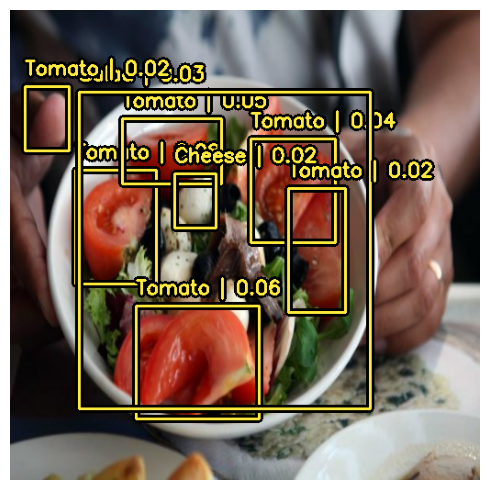

In [8]:
predictions_dict = {
    "boxes": tf.expand_dims(predictions[0]["boxes"], axis=0),
    "classes": tf.expand_dims(predictions[0]["classes"], axis=0),
    "confidence": tf.expand_dims(predictions[0]["confidence"], axis=0),
    "num_detections": predictions[0]["num_detections"],
}

label_map = get_label_map(os.path.join(model_dir, "label_map.yaml"))

visualization.plot_bounding_box_gallery(
    image_resized,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=predictions_dict,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=label_map,
)

### Clean up

In [ ]:
# Deletes custom train jobs.
train_job.delete()
# Undeploys models and deletes endpoints.
endpoint.delete(force=True)
# Deletes models.
model.delete()

In [9]:
endpoint.delete(force=True)

INFO:google.cloud.aiplatform.models:Undeploying Endpoint model: projects/633265597134/locations/us-central1/endpoints/7795069048978407424
INFO:google.cloud.aiplatform.models:Undeploy Endpoint model backing LRO: projects/633265597134/locations/us-central1/endpoints/7795069048978407424/operations/7537775116101353472
INFO:google.cloud.aiplatform.models:Endpoint model undeployed. Resource name: projects/633265597134/locations/us-central1/endpoints/7795069048978407424
INFO:google.cloud.aiplatform.base:Deleting Endpoint : projects/633265597134/locations/us-central1/endpoints/7795069048978407424
INFO:google.cloud.aiplatform.base:Delete Endpoint  backing LRO: projects/633265597134/locations/us-central1/operations/3485379876398039040
INFO:google.cloud.aiplatform.base:Endpoint deleted. . Resource name: projects/633265597134/locations/us-central1/endpoints/7795069048978407424


## References

- [Efficient Object Detection with YOLOV8 and KerasCV](https://keras.io/examples/vision/yolov8/)
- [Keras YOLOv8 API Documentation](https://keras.io/api/keras_cv/models/tasks/yolo_v8_detector/)
- [Keras YOLOv8 Backbones](https://keras.io/api/keras_cv/models/backbones/yolo_v8/)